In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict

import seaborn as sns

# load experimental data
data = pd.read_excel('data/data.xlsx', sheet_name = '1st Trial', names = ['time (min)', 'm_xylene', 'NO', 'NO2', 'NOx', 'NOx/m_xy', 'beta', 'NO,NO2 crossing time (min)', 'Wall loss factor', 'Peak O3 Concentration', '50% of Final M0 Time', 'PeakDp', 'deltaHC', 'm_xy consume ratio', 'deltaHC / beta', 'deltaHC * beta', 'M0', 'yield'])


In [54]:
X = data.iloc[:, :-2]
y = data.iloc[:, -2:]

In [59]:
def ImportanceValidation(model_type, X, y, runs, best, alpha = 0.1):
    feature_count = defaultdict(int)
    feature_freq = defaultdict(lambda: [0] * best)
    feature_avgs = None

    if model_type == 'forest':
        for _ in range(runs):
            state_1 = np.random.randint(1, 1000)
            state_2 = np.random.randint(1, 1000)
            X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.2, random_state = state_1)

            model = RandomForestRegressor(n_estimators = 100, random_state = state_2)
            model.fit(X_train, y_train)
            importances = model.feature_importances_
            feature_importances = pd.Series(importances, index = X.columns)
            feature_importances = feature_importances.sort_values(ascending = False)
            for i, feature in enumerate(feature_importances.index[:best]):
                feature_count[feature] += 1
                feature_freq[feature][i] += 1

            if feature_avgs is None:
                feature_avgs = feature_importances
            else:
                feature_avgs += feature_importances
    else:
        feature_counts = []
        feature_freqs = []
        feature_avgs_list = []
        for output in range(y.shape[1]):
            for _ in range(runs):
                state_1 = np.random.randint(1, 1000)
                state_2 = np.random.randint(1, 1000)
                X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.2, random_state = state_1)

                if model_type == 'lasso':
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    model = Lasso(alpha = alpha, max_iter = 5000, random_state = state_2)
                    model.fit(X_train, y_train.iloc[:, output])
                    coefficients = model.coef_
                    feature_coefficients = pd.Series(coefficients, index = X.columns)
                    feature_coefficients = feature_coefficients.sort_values(key=lambda x: np.abs(x), ascending=False)
                    for i, feature in enumerate(feature_coefficients.index[:best]):
                        feature_count[feature] += 1
                        feature_freq[feature][i] += 1

                    if feature_avgs is None:
                        feature_avgs = feature_coefficients
                    else:
                        feature_avgs += feature_coefficients

                elif model_type == 'boosting':
                    model = GradientBoostingRegressor(n_estimators = 100, random_state = state_2)
                    model.fit(X_train, y_train.iloc[:, output])
                    importances = model.feature_importances_
                    feature_importances = pd.Series(importances, index = X.columns)
                    feature_importances = feature_importances.sort_values(ascending = False)
                    for i, feature in enumerate(feature_importances.index[:best]):
                        feature_count[feature] += 1
                        feature_freq[feature][i] += 1

                    if feature_avgs is None:
                        feature_avgs = feature_importances
                    else:
                        feature_avgs += feature_importances

            feature_counts.append(feature_count)
            feature_freqs.append(feature_freq)
            feature_count = defaultdict(int)
            feature_freq = defaultdict(lambda: [0] * best)
            feature_avgs_list.append((feature_avgs / runs).sort_values(key=lambda x: np.abs(x), ascending = False))
            feature_avgs = None

    
    if model_type == 'forest':
        sorted_pairs = sorted(zip(feature_count.values(), list(feature_count)))
        best_features =[x[1] for x in reversed(sorted_pairs)]
        return feature_count, feature_freq, best_features[:best], (feature_avgs / runs).sort_values(key=lambda x: np.abs(x), ascending = False)
    else:
        best_set = []
        for feature_count in feature_counts:
            sorted_pairs = sorted(zip(feature_count.values(), list(feature_count)))
            best_features =[x[1] for x in reversed(sorted_pairs)]
            best_set.append(best_features[:best])
        return feature_counts, feature_freqs, best_set, feature_avgs_list


In [66]:
# nonlinear
feature_count_f, feature_freq_f, best_features_f, feature_avgs_list_f = ImportanceValidation('forest', X, y, 1000, 5)
best_features_f

['PeakDp', 'deltaHC / beta', 'm_xylene', 'deltaHC', 'Wall loss factor']

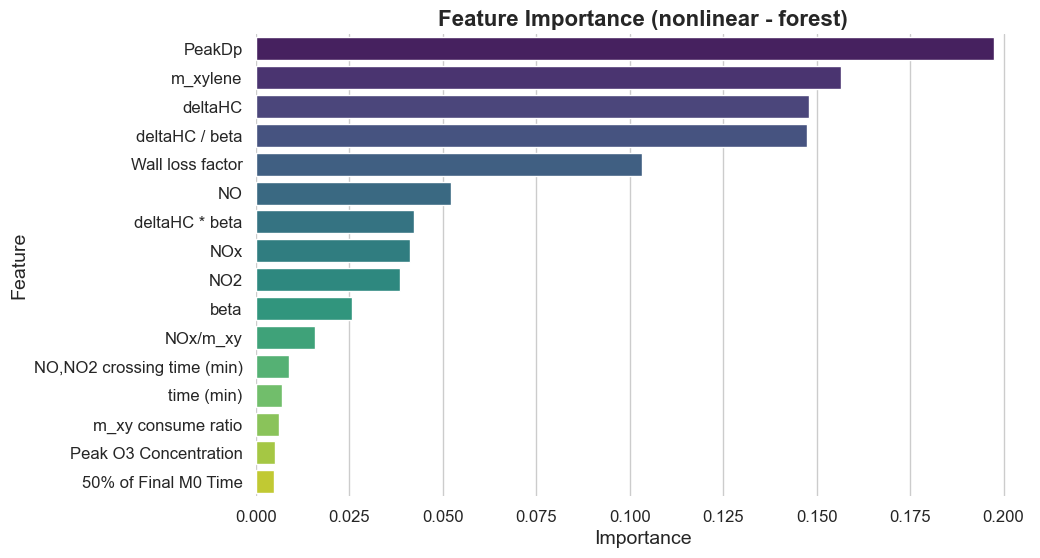

In [100]:
plt.figure(figsize = (10, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = feature_avgs_list_f.values, y = feature_avgs_list_f.index, palette = 'viridis')
plt.title('Feature Importance (nonlinear - forest)', fontsize = 16, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(left = True, bottom = True)
plt.show()

In [98]:
# linear
# if lasso doesn't have good coeffs / same frequency items, that means no strong linear dependence between inputs and outputs
# show that these results (best_features[0]) show in the correlations because we see high correlations
feature_counts_l, feature_freqs_l, best_features_l, feature_avgs_list_l = ImportanceValidation('lasso', X, y, 1000, 5)
best_features_l[0], best_features_l[1]

(['m_xylene', 'PeakDp', 'NO', '50% of Final M0 Time', 'deltaHC / beta'],
 ['time (min)', 'm_xylene', 'NOx', 'NO2', 'NO'])

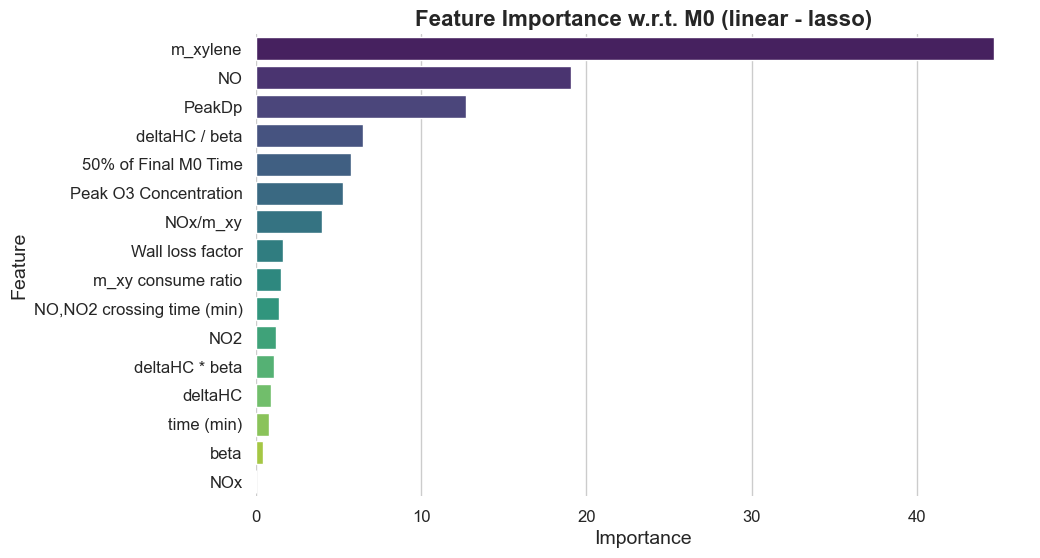

In [101]:
plt.figure(figsize = (10, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = np.abs(feature_avgs_list_l[0].values), y = feature_avgs_list_l[0].index, palette = 'viridis')
plt.title('Feature Importance w.r.t. M0 (linear - lasso)', fontsize = 16, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(left = True, bottom = True)
plt.show()

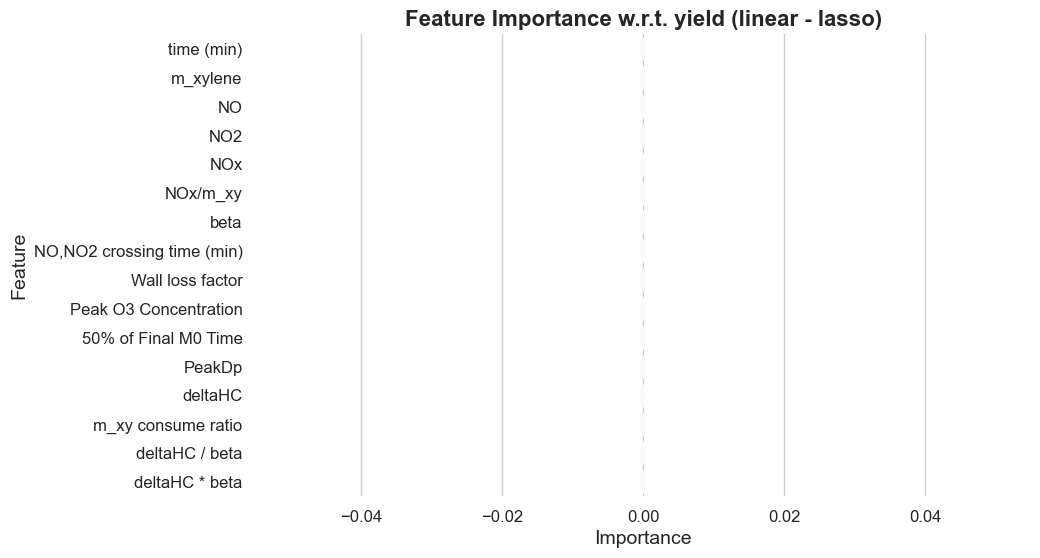

In [102]:
plt.figure(figsize = (10, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = np.abs(feature_avgs_list_l[1].values), y = feature_avgs_list_l[1].index, palette = 'viridis')
plt.title('Feature Importance w.r.t. yield (linear - lasso)', fontsize = 16, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(left = True, bottom = True)
plt.show()

Note to self: y.iloc[column, column] instead of y[y.columns[slice]]

In [60]:
# nonlinear
feature_counts_b, feature_freqs_b, best_features_b, feature_avgs_list_b = ImportanceValidation('boosting', X, y, 1000, 5)
best_features_b[0], best_features_b[1]

(['PeakDp', 'deltaHC / beta', 'm_xylene', 'deltaHC', 'beta'],
 ['deltaHC / beta',
  'PeakDp',
  'beta',
  'NO,NO2 crossing time (min)',
  'm_xy consume ratio'])

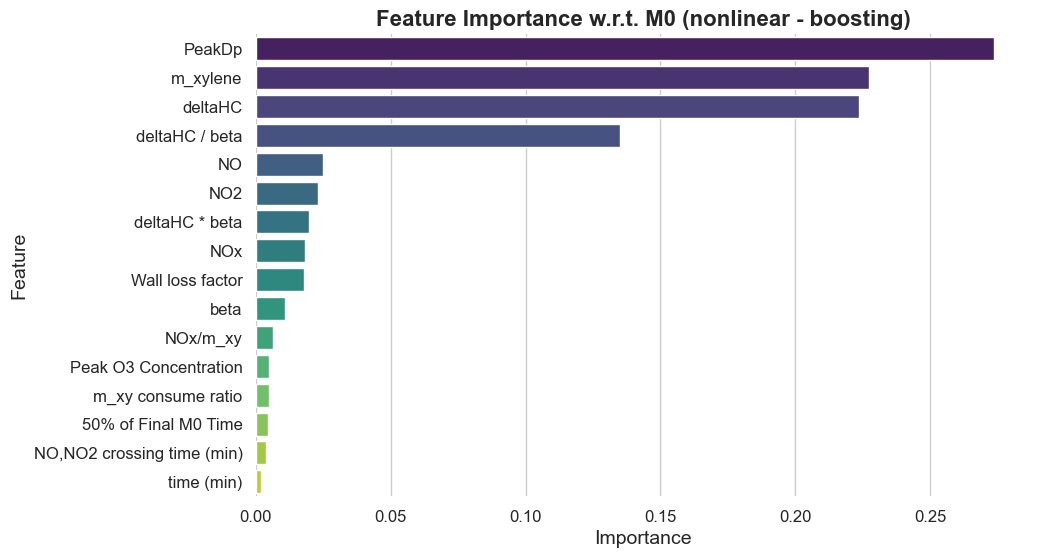

In [103]:
plt.figure(figsize = (10, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = np.abs(feature_avgs_list_b[0].values), y = feature_avgs_list_b[0].index, palette = 'viridis')
plt.title('Feature Importance w.r.t. M0 (nonlinear - boosting)', fontsize = 16, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(left = True, bottom = True)
plt.show()

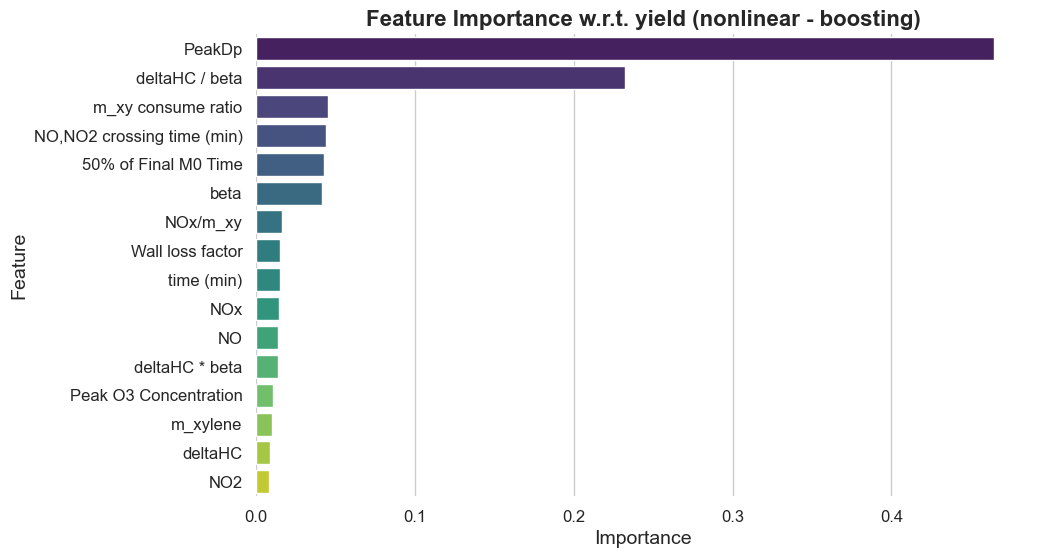

In [104]:
plt.figure(figsize = (10, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = np.abs(feature_avgs_list_b[1].values), y = feature_avgs_list_b[1].index, palette = 'viridis')
plt.title('Feature Importance w.r.t. yield (nonlinear - boosting)', fontsize = 16, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(left = True, bottom = True)
plt.show()